In [1]:
# librerias

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, time, datetime, timedelta
import numpy as np

from keras import Sequential, Input
from keras.layers import Flatten, Dense

import numpy as np

import pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as report

# Objetivo del análisis  
El objetivo de este análisis es predecir la tasa de abandono de los clientes de una determinada compañía (Churn).
- Tenemos que predecir si un cliente, según sus características abandonará la compañía (Churn = 1)
- O por el contrario, permanecerá (Churn = 0)

In [2]:
label_names = {0: 'Not churn', 
               1: 'churn'}

Cargamos los datos de entrenamiento

In [3]:
df_training = pd.read_csv('customer_churn_dataset-training-master.csv')

Comprobamos si hay nulos

In [4]:
df_training.isna().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Borramos los nulos

In [5]:
df_training.dropna(inplace=True)

Hacemos que la columna Customer ID sea el índice

In [6]:
df_training['CustomerID'] = df_training['CustomerID'].astype(int)
df_training.set_index('CustomerID', inplace=True)

In [7]:
df_training.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
CustomerID,,,,,,,,,,,
2,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
3,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
4,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
5,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
6,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [8]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440832 entries, 2 to 449999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 40.4+ MB


Convertimos las variables float a enteros porque todas son enteras

In [9]:
df_training['Age'] = df_training['Age'].astype(int)
df_training['Tenure'] = df_training['Tenure'].astype(int)
df_training['Usage Frequency'] = df_training['Usage Frequency'].astype(int)
df_training['Support Calls'] = df_training['Support Calls'].astype(int)
df_training['Payment Delay'] = df_training['Payment Delay'].astype(int)
df_training['Total Spend'] = df_training['Total Spend'].astype(int)
df_training['Last Interaction'] = df_training['Last Interaction'].astype(int)
df_training['Churn'] = df_training['Churn'].astype(int)

Cambiamos los nombres de las variables Usage Frequency, Support Calls, Payment Delay, Subscription Type,  
Contract Length, Total Spend y Last Interaction

In [10]:
df_training.rename(columns = {'Usage Frequency':'Usage_Frequency', 'Support Calls':'Support_Calls', 'Payment Delay':'Payment_Delay', 'Subscription Type':'Subscription_Type', 'Contract Length':'Contract_Length', 'Total Spend':'Total_Spend', 'Last Interaction':'Last_Interaction'}, inplace=True)

Vamos a observar las variables categóricas que nos quedan

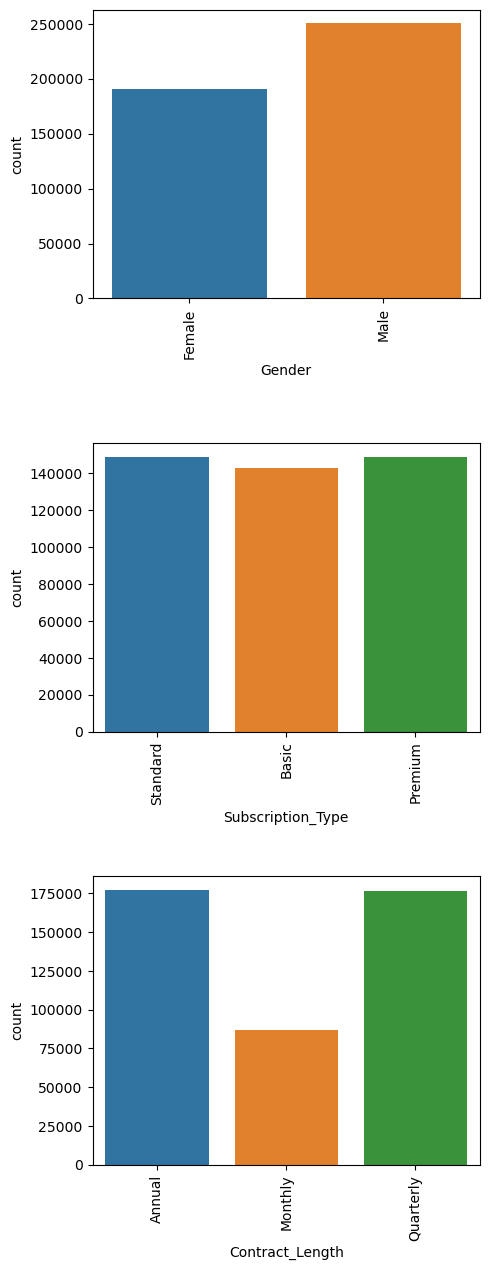

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,15))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(['Gender','Subscription_Type','Contract_Length']):
  sns.countplot(x=col, data=df_training, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

Vamos a cambiar Contract_Length a numérica que indique los días de contrato en meses
- 12 si es un año
- 3 si es 1/4 de año
- 1 si es un mes

In [12]:
def agrupacion(x):
    if x == 'Annual':
        return 12
    elif x == 'Quarterly':
        return 3
    elif x == 'Monthly':
        return 1
    else:
        return x
df_training['Contract_Length']=df_training['Contract_Length'].apply(agrupacion)

Vamos a cambiar Subcription_Type a numérica de tal manera que tenga un valor más alto si la suscripción es Premium
- 3 si es un Premium
- 2 si es Estándar
- 1 si es Basic

In [13]:
def agrupacion(x):
    if x == 'Premium':
        return 3
    elif x == 'Standard':
        return 2
    elif x == 'Basic':
        return 1
    else:
        return x
df_training['Subscription_Type']=df_training['Subscription_Type'].apply(agrupacion)

Convertimos la variable género a dummies

In [14]:
df_training = pd.get_dummies(df_training, columns=['Gender'])

Mantenemos la columna Gender_Male

In [15]:
df_training.drop('Gender_Female', axis=1, inplace=True)

In [16]:
df_training.head()

,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn,Gender_Male
CustomerID,,,,,,,,,,,
2,30,39,14,5,18,2,12,932,17,1,0
3,65,49,1,10,8,1,1,557,6,1,0
4,55,14,4,6,18,1,3,185,3,1,0
5,58,38,21,7,7,2,1,396,29,1,1
6,23,32,20,5,8,1,1,617,20,1,1


In [17]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440832 entries, 2 to 449999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Age                440832 non-null  int32
 1   Tenure             440832 non-null  int32
 2   Usage_Frequency    440832 non-null  int32
 3   Support_Calls      440832 non-null  int32
 4   Payment_Delay      440832 non-null  int32
 5   Subscription_Type  440832 non-null  int64
 6   Contract_Length    440832 non-null  int64
 7   Total_Spend        440832 non-null  int32
 8   Last_Interaction   440832 non-null  int32
 9   Churn              440832 non-null  int32
 10  Gender_Male        440832 non-null  uint8
dtypes: int32(8), int64(2), uint8(1)
memory usage: 24.0 MB


Examinamos los atípicos

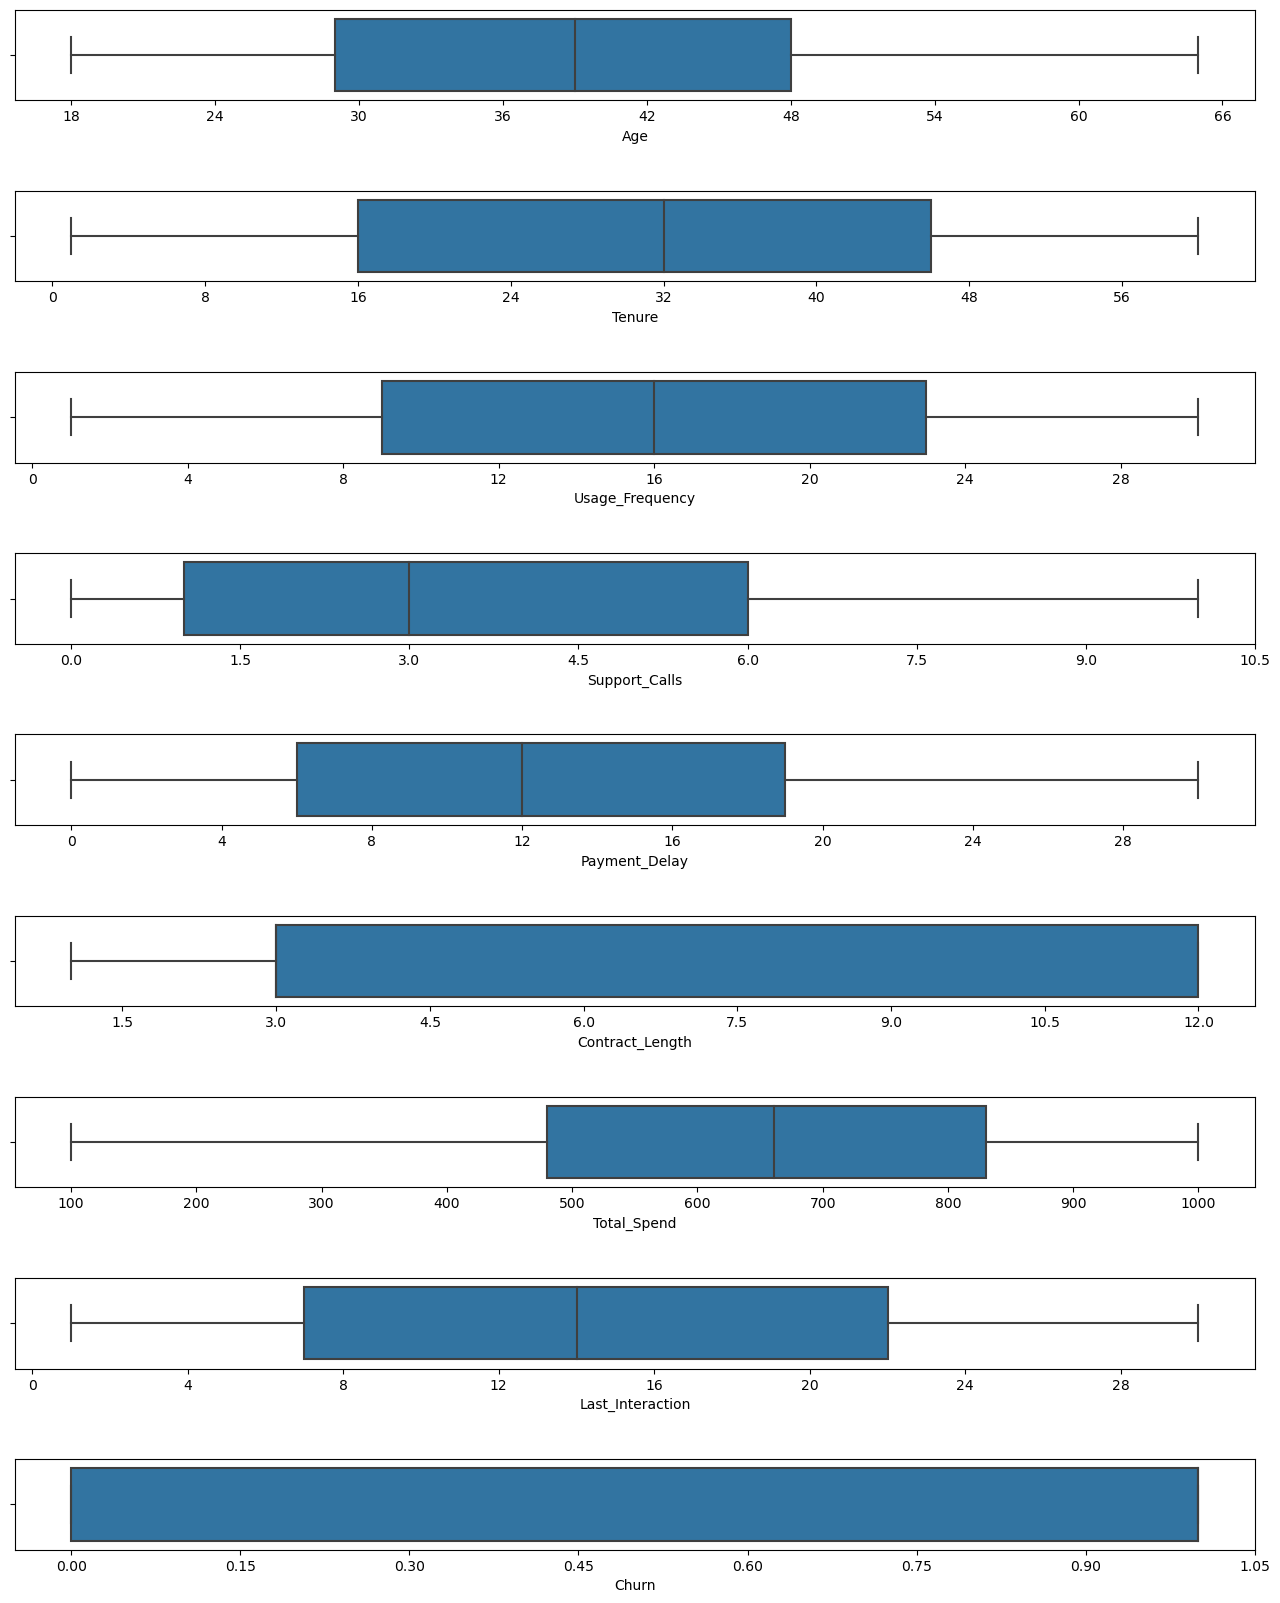

In [18]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(16,20))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['Age', 'Tenure', 'Usage_Frequency', 'Support_Calls',
       'Payment_Delay', 'Contract_Length', 'Total_Spend',
       'Last_Interaction', 'Churn']):
    sns.boxplot(x=col, data=df_training, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) 

No hay atípicos, así que la limpieza está finalizada

Cargamos el dataset de test

In [19]:
df_testing = pd.read_csv('customer_churn_dataset-testing-master.csv')

Comprobamos si hay nulos

In [20]:
df_testing.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

Hacemos que customerID sea la columna índice

In [21]:
df_testing['CustomerID'] = df_testing['CustomerID'].astype(int)
df_testing.set_index('CustomerID', inplace=True)

In [22]:
df_testing.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
CustomerID,,,,,,,,,,,
1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
3,47,Male,27,10,2,29,Premium,Annual,757,21,0
4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [23]:
df_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64374 entries, 1 to 64374
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                64374 non-null  int64 
 1   Gender             64374 non-null  object
 2   Tenure             64374 non-null  int64 
 3   Usage Frequency    64374 non-null  int64 
 4   Support Calls      64374 non-null  int64 
 5   Payment Delay      64374 non-null  int64 
 6   Subscription Type  64374 non-null  object
 7   Contract Length    64374 non-null  object
 8   Total Spend        64374 non-null  int64 
 9   Last Interaction   64374 non-null  int64 
 10  Churn              64374 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 5.9+ MB


Cambiamos los nombres de las variables Usage Frequency, Support Calls, Payment Delay, Subscription Type,  
Contract Length, Total Spend y Last Interaction

In [24]:
df_testing.rename(columns = {'Usage Frequency':'Usage_Frequency', 'Support Calls':'Support_Calls', 'Payment Delay':'Payment_Delay', 'Subscription Type':'Subscription_Type', 'Contract Length':'Contract_Length', 'Total Spend':'Total_Spend', 'Last Interaction':'Last_Interaction'}, inplace=True)

Vamos a observar las variables categóricas que nos quedan

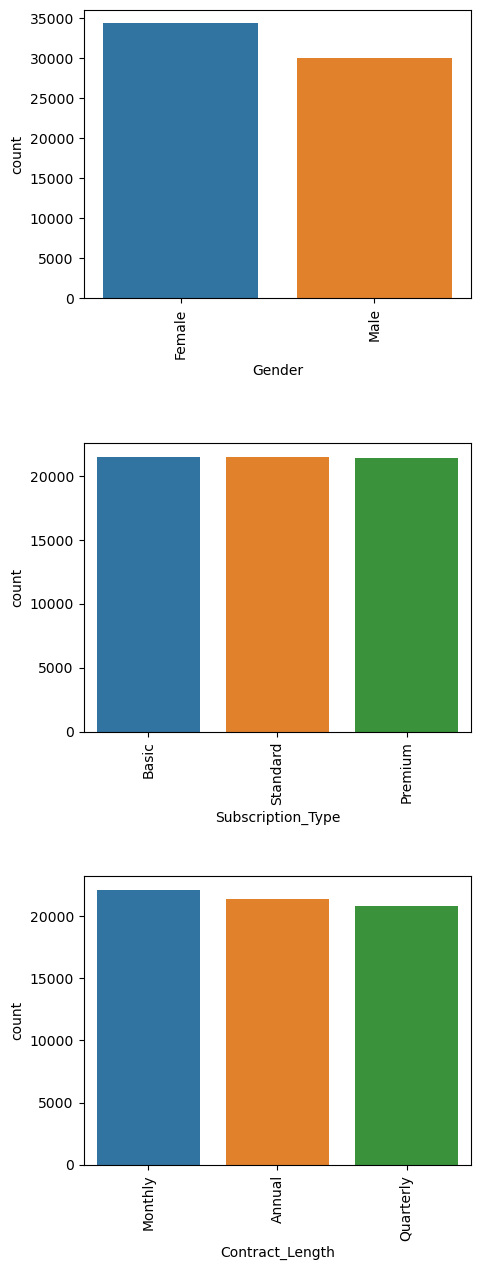

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,15))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(['Gender','Subscription_Type','Contract_Length']):
  sns.countplot(x=col, data=df_testing, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

Vamos a cambiar Contract_Length a numérica que indique los días de contrato en meses
- 12 si es un año
- 3 si es 1/4 de año
- 1 si es un mes

In [26]:
def agrupacion(x):
    if x == 'Annual':
        return 12
    elif x == 'Quarterly':
        return 3
    elif x == 'Monthly':
        return 1
    else:
        return x
df_testing['Contract_Length']=df_testing['Contract_Length'].apply(agrupacion)

Vamos a cambiar Subcription_Type a numérica de tal manera que tenga un valor más alto si la suscripción es Premium
- 3 si es un Premium
- 2 si es Estándar
- 1 si es Basic

In [27]:
def agrupacion(x):
    if x == 'Premium':
        return 3
    elif x == 'Standard':
        return 2
    elif x == 'Basic':
        return 1
    else:
        return x
df_testing['Subscription_Type']=df_testing['Subscription_Type'].apply(agrupacion)

Convertimos la variable género a dummies

In [28]:
df_testing = pd.get_dummies(df_testing, columns=['Gender'])

Mantenemos la columna Gender_Male

In [29]:
df_testing.drop('Gender_Female', axis=1, inplace=True)

In [30]:
df_testing.head()

,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn,Gender_Male
CustomerID,,,,,,,,,,,
1,22,25,14,4,27,1,1,598,9,1,0
2,41,28,28,7,13,2,1,584,20,0,0
3,47,27,10,2,29,3,12,757,21,0,1
4,35,9,12,5,17,3,3,232,18,0,1
5,53,58,24,9,2,2,12,533,18,0,0


In [31]:
df_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64374 entries, 1 to 64374
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                64374 non-null  int64
 1   Tenure             64374 non-null  int64
 2   Usage_Frequency    64374 non-null  int64
 3   Support_Calls      64374 non-null  int64
 4   Payment_Delay      64374 non-null  int64
 5   Subscription_Type  64374 non-null  int64
 6   Contract_Length    64374 non-null  int64
 7   Total_Spend        64374 non-null  int64
 8   Last_Interaction   64374 non-null  int64
 9   Churn              64374 non-null  int64
 10  Gender_Male        64374 non-null  uint8
dtypes: int64(10), uint8(1)
memory usage: 5.5 MB


Examinamos los atípicos

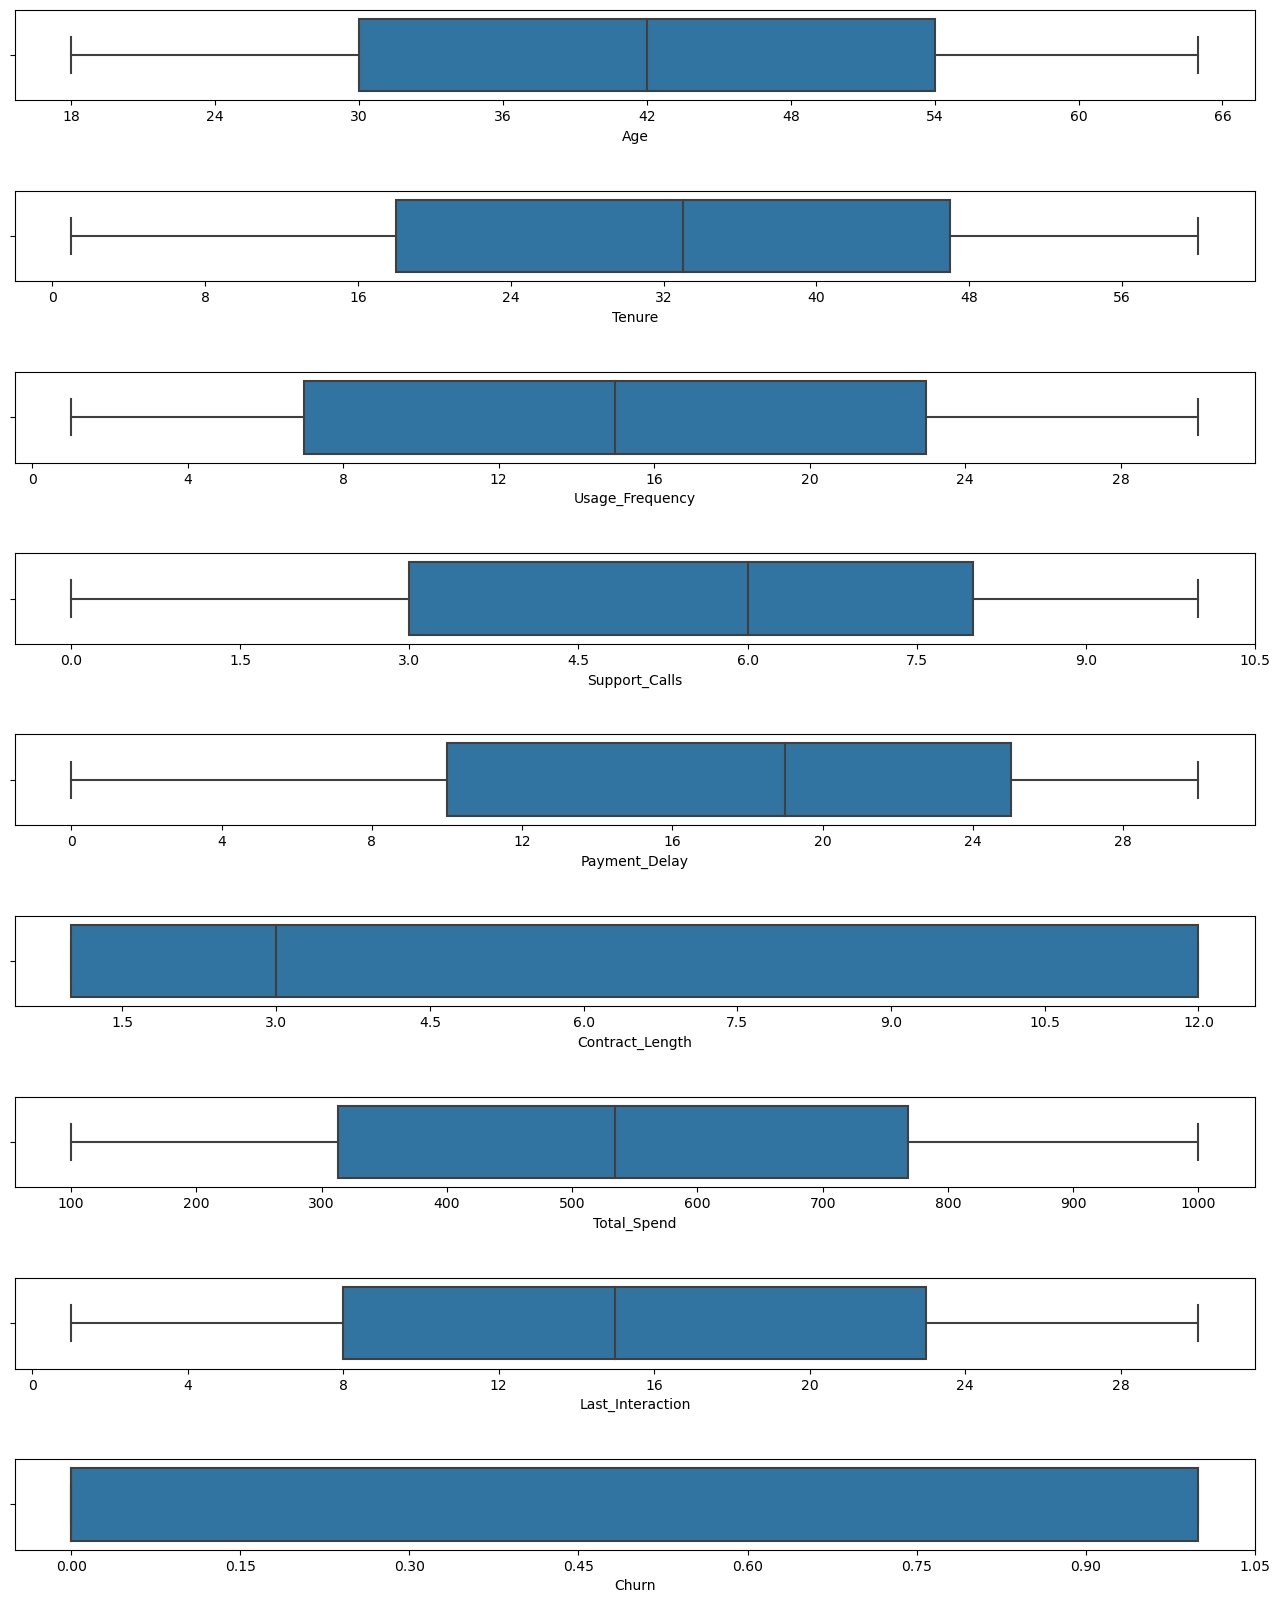

In [32]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(16,20))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['Age', 'Tenure', 'Usage_Frequency', 'Support_Calls',
       'Payment_Delay', 'Contract_Length', 'Total_Spend',
       'Last_Interaction', 'Churn']):
    sns.boxplot(x=col, data=df_testing, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) 

No hay atípicos, así que la limpieza está finalizada

Juntamos los dos datasets

In [33]:
df_completo = pd.concat([df_training,df_testing],join='inner')

**Caraga de datos**

In [34]:
X = df_completo.drop('Churn', axis=1)
y = df_completo.Churn

In [35]:
X_train, X_test, y_train, y_test = tts(X, y)
X_train, X_val, y_train, y_val = tts(X_train, y_train)

In [36]:
# Este es el tamaño de nuestos dataset de entrenamiento y prueba
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((284178, 10), (126302, 10), (284178,), (126302,))

### Exploración de los datos

Los datos de entrada en una red neuronal tienen que ser normalizados

In [37]:
X[X.columns] = StandardScaler().fit_transform(X)

In [38]:
X_train[X_train.columns] = StandardScaler().fit_transform(X_train)

In [39]:
X_test[X_test.columns] = StandardScaler().fit_transform(X_test)

Verificamos el pairplot

Como tarda mucho en generar el pairplot, vamos a guardarlo en imagen.  
El código para generarlo sería:  
sns.pairplot(df_completo, hue='Churn', palette='tab10')
plt.show();  
![Output](output.png)

### Modelo

Construir la red neuronal requiere configurar las capas del modelo y luego compilar el modelo. 

Los bloques de construccion básicos de una red neuronal son las *capas*. La función de las capas es extraer la características fundamentales de los clientes para luego clasificarlos. La mayoria de las capas como `Dense`, tienen parametros que son aprendidos durante el entrenamiento.

La primera capa de esta red, `Flatten`, 
transforma el formato de las imágenes de un df bidimensional (440832, 10) a un array unidimensional (10).

Después de que los datos sean "aplanados", la secuencia consiste de dos capas `Dense`. También se llama a estas capa `Full connected`, pues está todo conectado con todo. La primera capa `Dense` tiene 128 nodos o neuronas. La segunda capa es una capa de 10 nodos *softmax* (regresión logística) que devuelve un array de 10 probabilidades que suman a 1. Cada nodo contiene una calificacion que indica la probabilidad que la actual imagen pertenece a una de las 10 clases.

In [40]:
model = Sequential()

model.add(Flatten(input_shape=(10,)))

model.add(Dense(128, activation='relu'))

model.add(Dense(10, activation='softmax')) # Es una regresión logística que predice probabilidad

Antes de que el modelo este listo para entrenar, se necesitan algunas configuraciones más. Estas son agregadas durante el paso de compilación del modelo:

* *Loss function* — Función de coste o pérdida. Funcióin a minimizar para el ajuste.

* *Optimizer* — Algoritmo de optimización.

* *Metrics* — Métrica para el ajuste.

El siguiente ejemplo usa *accuracy* (acierto) , la proporción de imágenes que son correctamente clasificadas.

In [41]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2698 (10.54 KB)
Trainable params: 2698 (10.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Entrenamiento

In [43]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
8881/8881 [==============================] - 45s 5ms/step - loss: 0.3227 - accuracy: 0.8858
Epoch 2/50
8881/8881 [==============================] - 50s 6ms/step - loss: 0.2800 - accuracy: 0.9033
Epoch 3/50
8881/8881 [==============================] - 43s 5ms/step - loss: 0.2716 - accuracy: 0.9063
Epoch 4/50
8881/8881 [==============================] - 26s 3ms/step - loss: 0.2653 - accuracy: 0.9086
Epoch 5/50
8881/8881 [==============================] - 25s 3ms/step - loss: 0.2606 - accuracy: 0.9106
Epoch 6/50
8881/8881 [==============================] - 25s 3ms/step - loss: 0.2570 - accuracy: 0.9118
Epoch 7/50
8881/8881 [==============================] - 23s 3ms/step - loss: 0.2538 - accuracy: 0.9130
Epoch 8/50
8881/8881 [==============================] - 22s 3ms/step - loss: 0.2509 - accuracy: 0.9144
Epoch 9/50
8881/8881 [==============================] - 22s 2ms/step - loss: 0.2494 - accuracy: 0.9150
Epoch 10/50
8881/8881 [==============================] - 22s 2ms/step - l

### Evaluación y predicción

In [63]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

3947/3947 - 4s - loss: 0.2339 - accuracy: 0.9216 - 4s/epoch - 1ms/step

Test accuracy: 0.9216480851173401


In [64]:
y_prob = model.predict(X_test)

3947/3947 [==============================] - 5s 1ms/step


In [65]:
y_prob

array([[2.1135274e-01, 7.8864723e-01, 1.9651296e-30, ..., 1.4111552e-29,
        9.5682622e-30, 2.8454310e-28],
       [9.8193812e-01, 1.8061914e-02, 1.2432591e-20, ..., 5.5002890e-20,
        7.2867221e-21, 2.7145641e-20],
       [4.9969118e-02, 9.5003086e-01, 1.0064191e-22, ..., 3.0590617e-22,
        3.5950078e-22, 4.3319950e-21],
       ...,
       [9.9211055e-01, 7.8894729e-03, 1.6795736e-26, ..., 8.4903921e-27,
        7.4703125e-27, 6.2504068e-25],
       [9.4429320e-01, 5.5706792e-02, 4.4160891e-13, ..., 6.1101417e-13,
        5.2652224e-13, 2.0982474e-13],
       [3.0526251e-01, 6.9473749e-01, 6.4722099e-23, ..., 1.3935501e-22,
        1.2859944e-22, 1.2019622e-21]], dtype=float32)

In [66]:
y_prob[0]

array([2.1135274e-01, 7.8864723e-01, 1.9651296e-30, 2.2784080e-30,
       3.4732029e-30, 1.6287218e-29, 7.2214564e-30, 1.4111552e-29,
       9.5682622e-30, 2.8454310e-28], dtype=float32)

In [67]:
np.argmax(y_prob[0])

1

In [68]:
label_names[np.argmax(y_prob[0])]

'churn'

In [69]:
y_pred = np.argmax(y_prob, axis=1)

y_pred

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [70]:
y_test

CustomerID
31989     1
364124    0
5376      0
120528    1
316660    0
         ..
270135    0
62485     1
359041    0
275362    0
22935     1
Name: Churn, Length: 126302, dtype: int64

In [71]:
y_pred2 = pd.Series(y_pred)

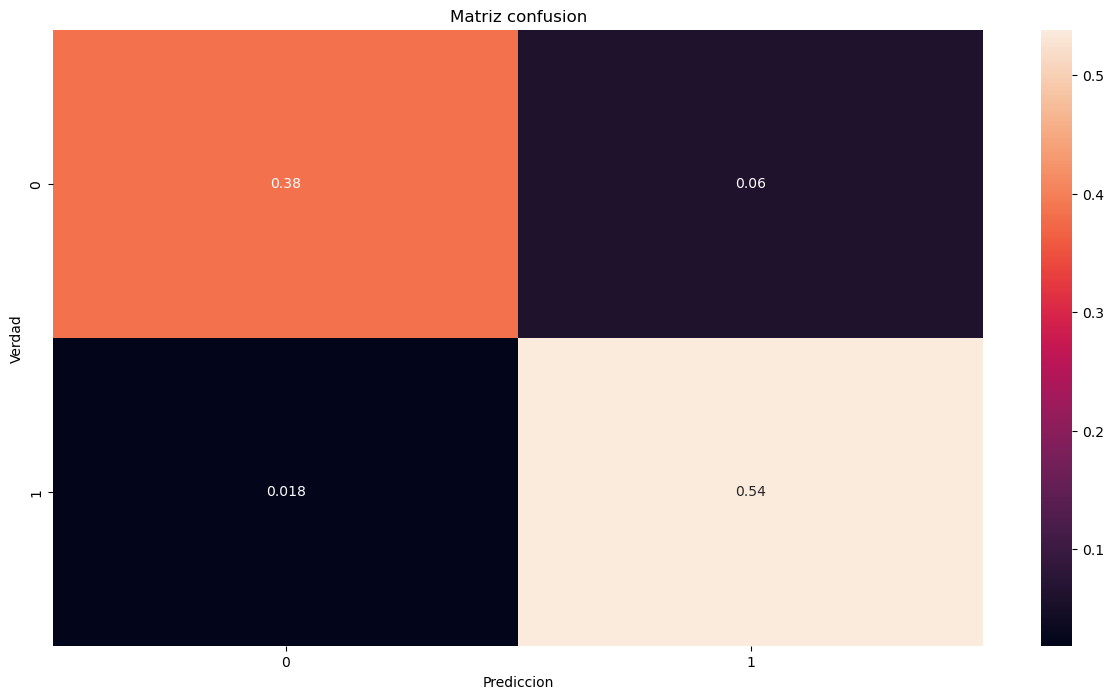

In [72]:
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, y_pred)/cm(y_test, y_pred).sum(), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [54]:
print(report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.91     55980
           1       0.90      0.97      0.93     70322

    accuracy                           0.92    126302
   macro avg       0.93      0.92      0.92    126302
weighted avg       0.92      0.92      0.92    126302



In [55]:
label_names

{0: 'Not churn', 1: 'churn'}

Parece que el modelo es bueno para predecir si un cliente abandona la compañía o no.  

- Precisión.Esto significa que cuando tu modelo predice que un cliente se quedará, está correcto el 95% de las veces.  
  Y cuando predice que un cliente abandonará, está correcto el 90% de las veces.

- Recall (sensibilidad): ativos. El tu modelo identifica correctamente el 86% de los clientes que se quedan y el 97% de los clientes que abandonan.

- F1-score: El F1-score es una medida que combina precisión y recall.Los F1-scores son del 91% para la clase 0 y del 93% para la clase 1, lo que indica que el modelo tiene un buen equilibrio entre precisión y recall.

### Guardado y carga del modelo

In [73]:
model

In [74]:
model.save_weights('MNIST_weights.h5')    # pesos de la red

In [75]:
model.load_weights('MNIST_weights.h5')

In [76]:
model.save('MNIST_Model.h5')              # modelo completo

In [77]:
from keras.models import load_model

In [78]:
modelo_nuevo = load_model('MNIST_Model.h5')

In [62]:
modelo_nuevo.predict(X_test)[0]

3947/3947 [==============================] - 6s 2ms/step


array([2.1135274e-01, 7.8864723e-01, 1.9651296e-30, 2.2784080e-30,
       3.4732029e-30, 1.6287218e-29, 7.2214564e-30, 1.4111552e-29,
       9.5682622e-30, 2.8454310e-28], dtype=float32)